<span style = "font-size:250%">
<center> Implementation of HHL Algorithm </center>
</span>

<center>
    <img src="https://qiskit.org/textbook/ch-applications/images/hhlcircuit.png" width = "50%" height = "50%">
    </center>


<span style = "font-size:150%">
1. QPE 파트에 대한 구현 
</span>

<center>
    <img src="https://qiskit.org/textbook/ch-algorithms/images/qpe_tex_qz.png" width = "50%" height = "50%">
    </center>

In [3]:
#QPE에 필요한 패키지 불러오기
import qiskit
from scipy.linalg import expm 
#scipy.linalg : 선형대수적 계산을 위한 패키지 
#https://docs.scipy.org/doc/scipy/reference/linalg.html
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import UnitaryGate
from qiskit.circuit.add_control import add_control
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

#for eigenvalue inversion
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library.arithmetic.piecewise_chebyshev import PiecewiseChebyshev
from qiskit import IBMQ, Aer, transpile, assemble

In [4]:
#참고 논문 :Low Complexity Quantum Matrix Inversion A기gorithm for non-Hermitian Matrices
#위 논문에서 제시한 상태와 CU gate를 입력하는 단계 

A_origin = np.array([[2,-1],[1,4]]) #non-Hermitian인 경우의 행렬에 대한 저장
A = np.vstack((np.hstack((np.zeros_like(A_origin),A_origin)),np.hstack((A_origin.T, np.zeros_like(A_origin))))) # Hermitian의 꼴로 바꿈
#A의 shape와 동일한 zero array를 생성하고, A_origin의 왼쪽에 배치, horizontal 방향도 마찬가지.
#A = np.matrix(A) 
b = np.array([1,1]) 
i = complex(0,1) #complex(real part, imaginary part)
t = np.pi*2/16
U = expm(i*A*t) #여기서 A가 행렬로 주어졌기 때문에, 행렬을 exp에 올리기 위해서는 expm이라는 scipy 패키지가 필요함.
#U = np.matrix(U)

U_gate = UnitaryGate(U) #위에서 구성한 U라는 행렬로써 Unitary gate를 구성할 수 있음. (4*4) 행렬
CU = add_control(U_gate,1,ctrl_state=None, label="CU") 
#CU라는 게이트 이름을 label에 저장
#control 되는 경우의 state를 지정 -> 해당사항 없음
#두번째 인자는 컨트롤 큐빗의 개수를 지정함.

n_l = 3 #QPE 상에서 n_ㅣ는 하다마드로 초기화 되는 부분 
#n_b = 2 #QPE 상에서 n_b는 psi에 해당하는 파트
n_b = int(np.log2(U.shape[0])) 
#Ax =b의 꼴이고, b는 4*1의 shape이므로, A의 행의 개수와 동일함. 따라서, U의 행렬의 행의 개수와 동일함.
#행의 개수에 log2를 취하면 필요한 n_b의 값을 구할 수 있음.

backend = Aer.get_backend('aer_simulator')
shots = 2048

In [6]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    #QFT의 역연산은 곧 QFT_dagger임을 기억하자.

    #Swap gate 걸어주기 (qiskit에서는 큐빗을 반대로 읽기 때문.)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
                qc.cp(-np.pi/float(2**(j-m)), m, j)
                qc.inverse()
                
        qc.h(j)
    qc.name = "QFT†"
    #display(qc.draw(output = 'mpl'))
    return qc

In [7]:
def QPE(n_l,n_b,CU):
    #circuit initialization for HHL
    nl_rg = QuantumRegister(n_l, "l")
    nb_rg = QuantumRegister(n_b, "b")
    #QuantumRegister(size=None, name=None, bits=None) 
    qc = QuantumCircuit(nl_rg,nb_rg)
    #display(qc.draw(output = 'mpl'))

    for l in range(n_l):
        qc.h(nl_rg[l]) #n_1 register에 하다마드 게이트를 모두 걸어줌
        for power in range(2**(l)):
            qc.append(CU, [nl_rg[l],nb_rg[0],nb_rg[1]]) 
            #첫번째 큐비트는 2^0번, 이후 2^n꼴로 돌아가게 설계됨.
            #https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html append의 예제.
            #즉, append의 첫번째 인자는 gate, 두번쨰 인자의 첫번째 요소는 control qubit, 이후 인자의 요소는 target qubit.

    qc.barrier()
    qc.append(qft_dagger(n_l), range(n_l)) 
        #append안에 들어간 qft_dagger라는 함수가 반환하는 qc라는 회로에 이름을 지정하면 간단히 이름으로 표기 가능
    qc.barrier()
    #qc.measure(nl_rg,classical_rg)
    #display(qc.draw(output = 'mpl'))
    #qc.name = "QPE"
    return qc

In [8]:
def QPE_dagger(n_l,n_b,CU):
    qc = QPE(n_l,n_b,CU)
    qc = qc.inverse() #controlled unitary check
    qc.name = 'QPE†' # -> name issue check
    #display(qc.draw(output='mpl'))
    return qc

In [9]:
def Eigenvalue_inversion(nl):

    f_x, degree, breakpoints, num_state_qubits = lambda x: np.arcsin(1 / x), 2, [1,2,3,4], nl
    #degree : 함수를 polynomial로 근사할 떄, 최고차항 정의
    #breakpoints는 구간을 나누는 느낌. : 근사를 할 떄, 다항식을 어떤 구간에서 나눠서 사용할 지
    #l : eigenvalue를 표현
    #f : rotation
    #a : ancila
    
    nl_rg = QuantumRegister(nl, "l")
    na_rg = QuantumRegister(nl, "a")
    nf_rg = QuantumRegister(1, "f")
    qc = QuantumCircuit(nl_rg, na_rg, nf_rg)

    pw_approximation = PiecewiseChebyshev(f_x, degree, breakpoints, num_state_qubits)
    pw_approximation._build()
    qc.append(pw_approximation,range(nl*2+1))
    #display(qc.draw(style = 'mpl'))

    return qc

In [15]:
def measurement(qc,n_l,n_b,CU,backend):
    t = transpile(qc, backend)
    qobj = assemble(t, shots=shots)
    results = backend.run(qobj).result()
    answer = results.get_counts()
    print(answer)
    display(plot_histogram(answer, title="Output Histogram"))


In [20]:
def seqential(CU,b,n_l,n_b,backend):
    n_f = 1

    nb = int(np.log2(b.shape))
    nl_rg = QuantumRegister(n_l, "l")
    nb_rg = QuantumRegister(n_b, "b")
    na_rg = QuantumRegister(n_l, "a")
    nf_rg = QuantumRegister(n_f, "f")
    
    cf = ClassicalRegister(n_f, "classical_f")
    cb = ClassicalRegister(n_b, "classical_b")

    qc = QuantumCircuit(nf_rg,nl_rg, na_rg, nb_rg, cf, cb)
    qc.h(7)
    #QPE 회로 추가
    qc += QPE(n_l,n_b,CU)

    #Eigenvalue_inversion 회로 추가
    qc += Eigenvalue_inversion(n_l)
    qc.barrier(nf_rg)
    
    #QPE_dagger 회로 추가
    qc += QPE_dagger(n_l,n_b,CU)

    qc.measure(nb_rg,cb)
    qc.measure(nf_rg,cf)
    #display(qc.draw(output = 'mpl'))

    measurement(qc,n_l,n_b,CU,backend)
    display(qc.draw(output = 'mpl'))
    return qc

C:\Users\march\AppData\Local\Temp\ipykernel_8476\3621552051.py:16: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += QPE(n_l,n_b,CU)
C:\Users\march\AppData\Local\Temp\ipykernel_8476\3621552051.py:19: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += Eigenvalue_inversion(n_l)
C:\Users\march\AppData\Local\Temp\ipykernel_8476\3621552051.py:23: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += QPE_dagger(n_l,n_b,CU)


{'01 0': 768, '00 0': 1081, '11 0': 149, '10 0': 50}


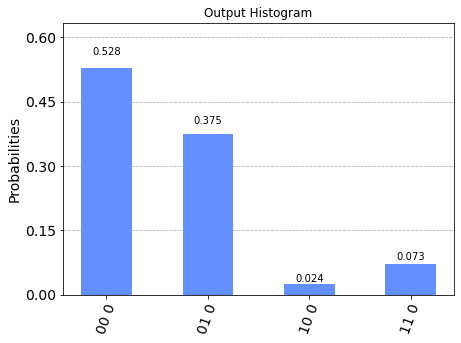

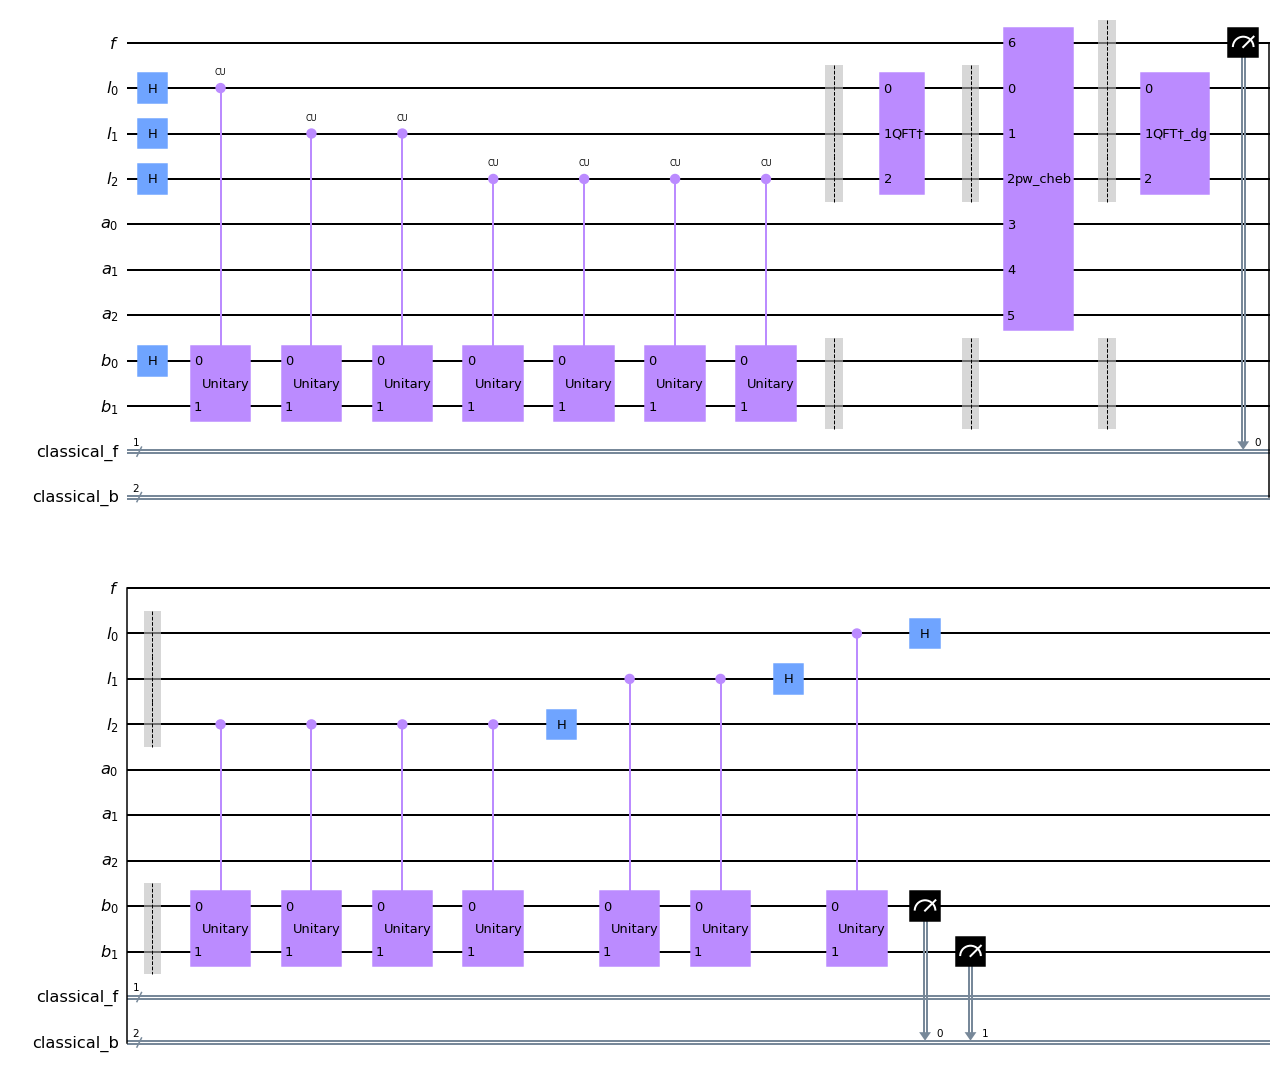

In [21]:
seqential(CU,b,n_l,n_b,backend)